In [151]:
!pip install -U numpy==1.26.4 catboost shap optuna --quiet

# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Отправка финального решения на лидерборд на Kaggle
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти


In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import shap
import optuna

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [153]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1190,C-9596685X,Kia Rio X-line,economy,petrol,4.30,2014,65593,2014,45.40,engine_overheat
1728,B-1876818F,Kia Rio,economy,petrol,5.30,2013,37578,2016,42.13,engine_check
181,q-1404140E,VW Tiguan,economy,petrol,4.56,2015,82940,2021,20.56,electro_bug
514,Z-7997184C,Kia Rio,economy,petrol,3.46,2011,4848,2021,26.27,gear_stick
853,I15203455u,Smart ForTwo,economy,petrol,4.66,2017,136056,2021,26.50,gear_stick


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [154]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
190239,D16051881Q,N12915117c,H1l,2020-01-31,2.64,63,873,61,163.405694,1,3282.092426,0,0.336409,28.639
231434,Q16921397P,Q-2285147y,U1O,2020-01-08,5.48,17,232,34,44.536868,0,620.243553,0,-2.714799,-39.320
492658,V65533867O,i21617445N,T1c,2020-02-03,6.61,34,471,40,69.000000,2,1402.376342,0,0.008983,-0.001
245668,P13407160Y,R-1779027F,a1X,2020-03-22,7.48,39,421,67,84.413270,0,2318.893504,0,1.532618,-11.921
352619,P14230452S,Z-6848638K,R1h,2020-02-20,3.48,57,734,48,71.000000,1,2300.778994,0,0.560671,-6.452


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [155]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
6152,18,9.6,921,22.0,M20466264Z,1,2020-10-12
7290,44,8.2,2026,8.0,a24835745r,0,2018-2-30
5476,40,6.6,323,11.0,V10687219T,0,2019-8-21
446,21,8.9,992,18.0,M17389205n,1,2020-11-2
5058,30,7.4,7,1.0,G20986811u,0,2020-2-14


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [156]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
117836,j-1650243q,RP,2019-12-7 6:52,reparking,1.0,23
53800,d88026009F,PJ,2019-7-13 11:59,reparking,1.0,31
11690,m13540768n,OH,2019-2-16 20:14,reparking,1.0,27
52796,H-1751594v,NG,2021-11-28 9:54,reparking,1.0,25
95622,z-1923449T,NL,2020-10-1 10:42,refuel_check,1.0,28


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.

6. **ОБЯЗАТЕЛЬНО!** Проверьте, что кол-во строк в полученном датафрейме равно изначальному кол-ву строк в исходном датасете car_train. Убедитесь, что нет дублей. (За это будут снижать баллы)


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [157]:
# Базовая агрегация по car_id
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count')
).reset_index()

rides_agg.head()

,car_id,min_rating,mean_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


In [158]:
# Группировка по car_id и расчёт обязательных признаков
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),             # минимальный рейтинг
    mean_rating=('rating', 'mean'),           # средний рейтинг
    total_distance=('distance', 'sum'),       # суммарная дистанция
    max_speed=('speed_max', 'max'),           # максимальная скорость
    total_rides=('ride_id', 'count')          # количество поездок
).reset_index()

rides_agg.head()

,car_id,min_rating,mean_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


In [159]:
# Соединение car_train и rides_agg по car_id
car_train_merged = car_train.merge(rides_agg, on='car_id', how='left')

# Проверка
print(f'Размер car_train: {car_train.shape}')
print(f'Размер после объединения: {car_train_merged.shape}')

Размер car_train: (2337, 10)
Размер после объединения: (2337, 15)


In [160]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,4.737759,1.214131e+07,180.855726,174
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,4.480517,1.803909e+07,187.862734,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,4.768391,1.588366e+07,102.382857,174
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,3.880920,1.651883e+07,172.793237,174
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,4.181149,1.398317e+07,203.462289,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,4.608908,1.739222e+07,141.502350,174
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,4.683793,1.174052e+07,155.000000,174
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,4.655345,1.202022e+07,104.180940,174
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,4.638333,1.788307e+07,200.000000,174


In [161]:
# Присоединение информации о водителях к поездкам
rides_with_drivers = rides_info.merge(driver_info, on='user_id', how='left')

# Агрегация по car_id
drivers_agg = rides_with_drivers.groupby('car_id').agg(
    driver_age_mean=('age', 'mean'),
    driver_rating_mean=('user_rating', 'mean'),
    driver_accident_mean=('user_time_accident', 'mean')
).reset_index()

# Объединение с основным датафреймом
car_train_merged = car_train_merged.merge(drivers_agg, on='car_id', how='left')

car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides,driver_age_mean,driver_rating_mean,driver_accident_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,4.737759,1.214131e+07,180.855726,174,33.511494,8.229885,17.724138
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,4.480517,1.803909e+07,187.862734,174,34.988506,7.988506,6.965517
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,4.768391,1.588366e+07,102.382857,174,32.839080,7.843103,9.775862
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,3.880920,1.651883e+07,172.793237,174,34.977011,8.524138,19.991304
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,4.181149,1.398317e+07,203.462289,174,34.298851,8.112069,15.758333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,4.608908,1.739222e+07,141.502350,174,32.632184,8.124138,20.203390
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,4.683793,1.174052e+07,155.000000,174,34.977011,8.150575,18.041322
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,4.655345,1.202022e+07,104.180940,174,33.287356,7.783908,8.804598
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,4.638333,1.788307e+07,200.000000,174,31.977011,8.084483,17.008547


In [162]:
print(f"Ожидается: {car_train.shape[0]} строк")
print(f"Фактически: {car_train_merged.shape[0]} строк")

Ожидается: 2337 строк
Фактически: 2337 строк


In [163]:
duplicates = car_train_merged['car_id'].duplicated().sum()
print(f"Количество дубликатов по car_id: {duplicates}")

Количество дубликатов по car_id: 0


In [164]:
fix_agg = fix_info.groupby('car_id').agg(
    fix_count=('fix_date', 'count'),                 # Кол-во ремонтов
    avg_destroy_degree=('destroy_degree', 'mean'),   # Средний износ
    total_work_duration=('work_duration', 'sum'),    # Суммарная длительность ремонта
    unique_work_types=('work_type', 'nunique')       # Уникальных типов работ
).reset_index()

fix_agg.head()

,car_id,fix_count,avg_destroy_degree,total_work_duration,unique_work_types
0,A-1049127W,35,2.714286,962,4
1,A-1079539w,34,4.329412,931,4
2,A-1162143G,34,3.705882,946,3
3,A-1228282M,34,2.908824,838,4
4,A-1339912r,34,3.044118,973,4


In [165]:
car_train_merged = car_train_merged.merge(fix_agg, on='car_id', how='left')

In [166]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,total_distance,max_speed,total_rides,driver_age_mean,driver_rating_mean,driver_accident_mean,fix_count,avg_destroy_degree,total_work_duration,unique_work_types
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.214131e+07,180.855726,174,33.511494,8.229885,17.724138,35,3.048571,933,4
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,1.803909e+07,187.862734,174,34.988506,7.988506,6.965517,35,2.917143,873,5
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,1.588366e+07,102.382857,174,32.839080,7.843103,9.775862,35,3.740000,915,5
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1.651883e+07,172.793237,174,34.977011,8.524138,19.991304,35,4.085714,1007,4
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,1.398317e+07,203.462289,174,34.298851,8.112069,15.758333,35,3.880000,981,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,1.739222e+07,141.502350,174,32.632184,8.124138,20.203390,34,3.900000,814,4
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,1.174052e+07,155.000000,174,34.977011,8.150575,18.041322,34,1.935294,873,4
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,1.202022e+07,104.180940,174,33.287356,7.783908,8.804598,34,2.782353,797,4
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,1.788307e+07,200.000000,174,31.977011,8.084483,17.008547,34,3.441176,857,4


### Идеи для новых признаков


* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [167]:
# YOUR CODE HERE
# Расчёт дополнительных признаков по deviation_normal и user_ride_quality
rides_extra = rides_info.groupby('car_id').agg(
    feature_min_max_diff=('deviation_normal', lambda x: x.max() - x.min()),  # разница между max и min
    feature_corner=('user_ride_quality', lambda x: np.polyfit(range(len(x)), x.fillna(0), 1)[0]),  # угол наклона
    feature_mean=('deviation_normal', 'mean'),  # среднее значение
    feature_shift=('deviation_normal', lambda x: x.diff().abs().idxmax() if len(x) > 1 else np.nan),  # точка перегиба (можно уточнить)
    feature_start=('deviation_normal', lambda x: x.iloc[0] if len(x) > 0 else np.nan),  # стартовое значение
    feature_nans=('deviation_normal', lambda x: x.isna().sum()),  # количество пропусков
    feature_quant=('deviation_normal', lambda x: x.quantile(0.75))  # 75% квантиль
).reset_index()

rides_extra

,car_id,feature_min_max_diff,feature_corner,feature_mean,feature_shift,feature_start,feature_nans,feature_quant
0,A-1049127W,31.688,0.013702,-6.136672,99,2.909,0,-0.53250
1,A-1079539w,74.349,-0.163212,47.443270,280,60.924,0,59.06075
2,A-1162143G,46.177,0.016630,10.556425,477,-1.219,0,17.22600
3,A-1228282M,64.898,-0.138497,9.810747,613,6.644,0,25.68825
4,A-1339912r,40.142,-0.056324,22.965937,798,0.490,0,31.29600
...,...,...,...,...,...,...,...,...
4245,z73688663a,67.991,0.039323,-13.846075,738742,1.271,0,-7.52825
4246,z73740510r,59.877,0.127216,7.026477,738919,1.685,0,21.40925
4247,z86911952C,75.449,-0.080211,-25.382126,738996,-50.624,0,-14.24300
4248,z91353693Z,60.076,0.085543,-8.031167,739258,5.755,0,4.79100


In [168]:
car_train_merged = car_train_merged.merge(rides_extra, on='car_id', how='left')
print("Форма после объединения:", car_train_merged.shape)
print("Дубликатов по car_id:", car_train_merged['car_id'].duplicated().sum())

Форма после объединения: (2337, 29)
Дубликатов по car_id: 0


In [169]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,avg_destroy_degree,total_work_duration,unique_work_types,feature_min_max_diff,feature_corner,feature_mean,feature_shift,feature_start,feature_nans,feature_quant
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,3.048571,933,4,9.001,-0.012377,-0.120391,718399,0.000,0,0.00100
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,2.917143,873,5,72.761,0.147758,6.050011,210544,-7.057,0,16.69100
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,3.740000,915,5,16.401,0.024377,-2.223954,412085,-0.000,0,0.00000
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,4.085714,1007,4,61.647,-0.028008,14.771948,663553,-0.833,0,28.18550
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,3.880000,981,4,70.176,-0.010186,12.455678,188363,-0.160,0,30.65725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,3.900000,814,4,31.650,-0.046928,2.914989,506705,11.105,0,7.75275
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,1.935294,873,4,55.181,-0.060359,-18.805856,469026,-0.506,0,-7.97800
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,2.782353,797,4,106.793,0.013394,-7.651776,10170,5.281,0,24.12925
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,3.441176,857,4,51.144,-0.073751,0.468718,314338,2.417,0,6.28000


In [170]:
# Запись итогового DataFrame в CSV файл
car_train_merged.to_csv('car_train_merged.csv', index=False, encoding='utf-8-sig')
print('Файл car_train_merged успешно сохранён!')

Файл car_train_merged успешно сохранён!


## 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [171]:
# Проверка на константные признаки
constant_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() == 1]
print("Константные признаки:", constant_cols)

Константные признаки: ['total_rides', 'feature_nans']


In [172]:
# Удаление константных признаков
const_cols = ['total_rides', 'feature_nans']
existing_cols = [col for col in const_cols if col in car_train_merged.columns]

if existing_cols:
    car_train_merged.drop(columns=existing_cols, inplace=True)
    print(f"Удалены константные признаки: {existing_cols}")
else:
    print("Константные признаки уже отсутствуют в датафрейме.")

Удалены константные признаки: ['total_rides', 'feature_nans']


In [173]:
# Генерация дополнительных признаков по rides_info
extra_features = rides_info.groupby('car_id').agg({
    'ride_duration': ['mean', 'std'],
    'speed_avg': ['mean', 'std'],
    'refueling': lambda x: x.sum() / x.count() if x.count() > 0 else 0,
    'deviation_normal': lambda x: x.isna().sum(),
    'user_ride_quality': lambda x: np.polyfit(range(len(x)), x.fillna(0), 1)[0]
}).reset_index()

# Переименование колонок
extra_features.columns = [
    'car_id',
    'ride_duration_mean', 'ride_duration_std',
    'speed_avg_mean', 'speed_avg_std',
    'refueling_rate',
    'feature_nans',
    'user_ride_quality_trend'
]

# Присоединение к основному датафрейму (без переименования)
car_train_merged = car_train_merged.merge(extra_features, on='car_id', how='left')

# Проверка результата
print(f"Размер датафрейма после добавления новых признаков: {car_train_merged.shape}")
display(car_train_merged.head())

Размер датафрейма после добавления новых признаков: (2337, 34)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,feature_shift,feature_start,feature_quant,ride_duration_mean,ride_duration_std,speed_avg_mean,speed_avg_std,refueling_rate,feature_nans,user_ride_quality_trend
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,718399,0.000,0.00100,1635.770115,6147.762726,44.660920,9.736706,0.0,0,-0.012377
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,210544,-7.057,16.69100,2223.178161,7783.909309,49.862069,15.183024,0.0,0,0.147758
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,412085,-0.000,0.00000,2048.856322,7356.080523,44.005747,9.675365,0.0,0,0.024377
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,663553,-0.833,28.18550,1943.511494,7476.617275,49.344828,14.815105,0.0,0,-0.028008
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,188363,-0.160,30.65725,1597.793103,6316.543271,50.603448,14.754962,0.0,0,-0.010186


In [174]:
car_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   car_id                   2337 non-null   object 
 1   model                    2337 non-null   object 
 2   car_type                 2337 non-null   object 
 3   fuel_type                2337 non-null   object 
 4   car_rating               2337 non-null   float64
 5   year_to_start            2337 non-null   int64  
 6   riders                   2337 non-null   int64  
 7   year_to_work             2337 non-null   int64  
 8   target_reg               2337 non-null   float64
 9   target_class             2337 non-null   object 
 10  min_rating               2337 non-null   float64
 11  mean_rating              2337 non-null   float64
 12  total_distance           2337 non-null   float64
 13  max_speed                2337 non-null   float64
 14  driver_age_mean         

In [175]:
# Проверка почти-уникальных признаков
n_rows = car_train_merged.shape[0]
unique_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() >= n_rows * 0.99]

# Принудительное удаление явных ID и бесполезных признаков
forced_drop = ['car_id', 'total_distance']  # total_distance нет в новых данных, но пусть будет на всякий случай
unique_cols = list(set(unique_cols + forced_drop))

# Исключение осознанно добавленных фичей, даже если они почти уникальны
protected = [
    'feature_mean', 'feature_corner', 'feature_shift', 'feature_start', 'feature_nans', 'feature_quant',
    'feature_min_max_diff', 'ride_duration_mean', 'ride_duration_std',
    'speed_avg_mean', 'speed_avg_std', 'refueling_rate', 'user_ride_quality_trend'
]
unique_cols = [col for col in unique_cols if col not in protected]

print("Финальные признаки для удаления:", unique_cols)

# Удаление
car_train_merged.drop(columns=unique_cols, inplace=True)


Финальные признаки для удаления: ['car_id', 'total_distance']


In [176]:
# # Permutation Importance

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import permutation_importance
# from sklearn.model_selection import train_test_split

# # Определение числовых признаков
# numeric_cols = car_train_merged.select_dtypes(include=['int64', 'float64']).columns.tolist()
# numeric_cols = [col for col in numeric_cols if col != 'target_reg']

# # Подготовка X и y
# X = car_train_merged[numeric_cols]
# y = car_train_merged['target_reg']

# # Разделение на train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# # Обучение модели
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Расчёт permutation importance
# perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# # Сортировка и визуализация
# sorted_idx = perm_importance.importances_mean.argsort()[::-1]
# plt.figure(figsize=(10, 8))
# sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=X.columns[sorted_idx])
# plt.title('Permutation Importance (Random Forest)')
# plt.xlabel('Importance')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

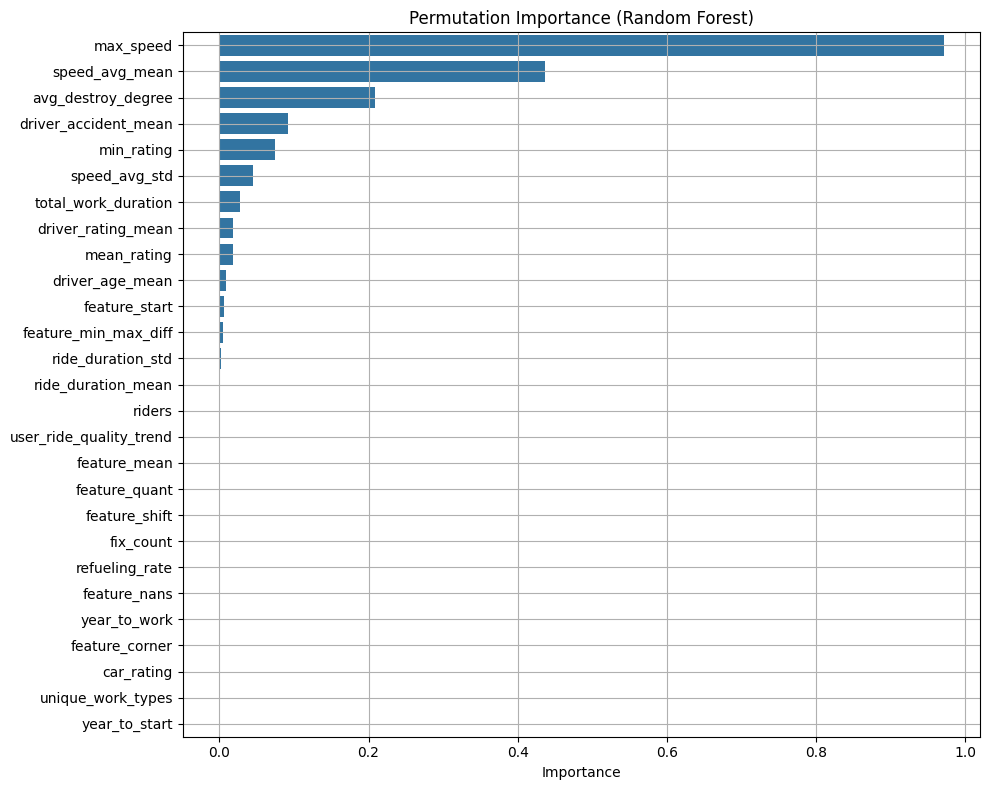

In [177]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Обновлённый список числовых признаков (все, кроме object и target)
numeric_cols = car_train_merged.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['target_reg', 'target_class']]

# Подготовка X и y
X = car_train_merged[numeric_cols]
y = car_train_merged['target_reg']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Обучение модели
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Расчёт permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Сортировка и визуализация
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
sorted_features = np.array(X.columns)[sorted_idx]
sorted_importances = perm_importance.importances_mean[sorted_idx]

# Фильтрация от None и NaN
valid_idx = ~pd.isnull(sorted_features) & ~pd.isnull(sorted_importances)

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances[valid_idx], y=sorted_features[valid_idx])
plt.title('Permutation Importance (Random Forest)')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

 97%|=================== | 566/585 [00:27<00:00]       

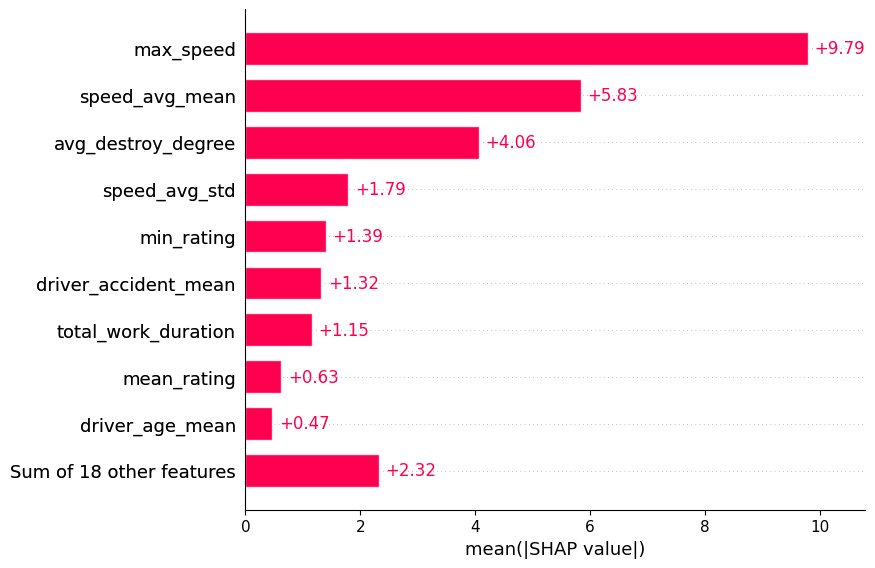

In [178]:
import shap

# SHAP требует TreeExplainer для деревьев
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test)

# Визуализация важности признаков
shap.plots.bar(shap_values)

In [179]:
# Установка библиотеки (если ещё не установлена)
!pip install phik --quiet

from phik import report
import pandas as pd

# Phik требует правильной типизации: укажем, какие признаки считаем числовыми
numeric_cols = car_train_merged.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Расчёт phik-корреляции
phik_matrix = car_train_merged.phik_matrix(interval_cols=numeric_cols)

# Корреляция с целевой переменной target_reg
phik_target = phik_matrix['target_reg'].sort_values(ascending=False)

# Отображение значимых корреляций (по желанию можно ограничить топ-20)
print(phik_target.head(20))

/usr/local/lib/python3.11/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable feature_nans for analysis 1. Dropping this column
  warnings.warn(


target_reg                 1.000000
target_class               0.639768
avg_destroy_degree         0.559280
max_speed                  0.491154
mean_rating                0.467880
driver_accident_mean       0.461232
fuel_type                  0.396224
model                      0.344664
driver_rating_mean         0.310431
feature_min_max_diff       0.244835
speed_avg_std              0.220980
total_work_duration        0.212795
car_type                   0.205868
speed_avg_mean             0.202995
feature_mean               0.198857
driver_age_mean            0.162450
feature_quant              0.157915
feature_start              0.155079
user_ride_quality_trend    0.125051
feature_corner             0.125051
Name: target_reg, dtype: float64


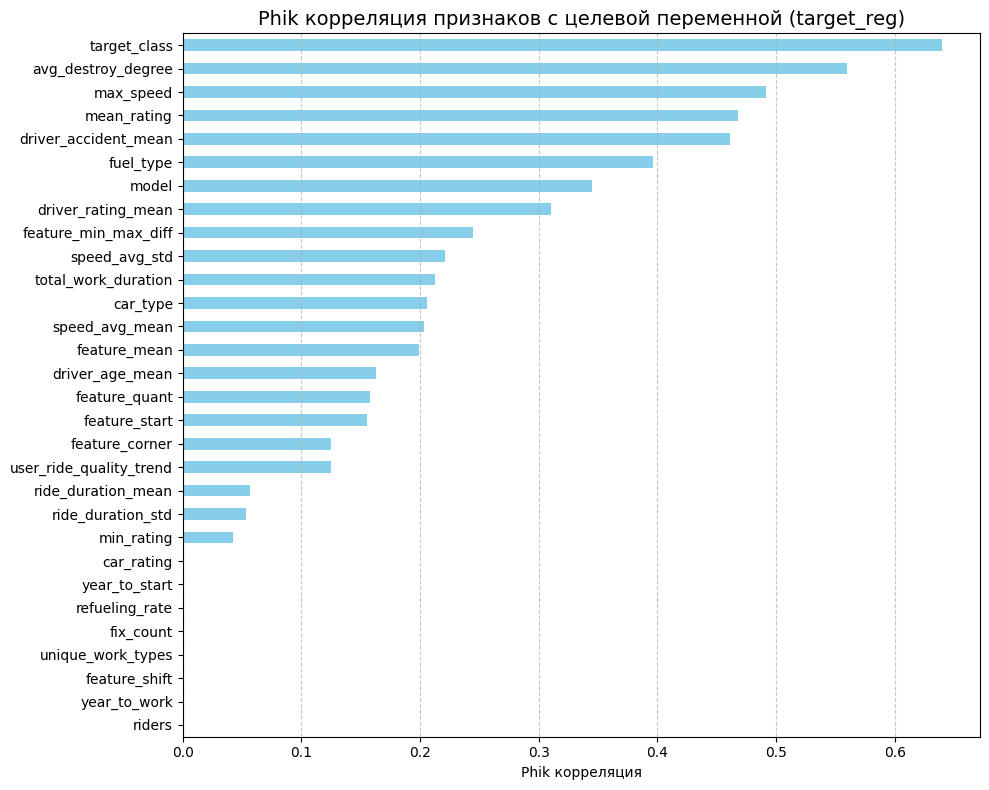

In [180]:
# Удаление строки target_reg, чтобы не мешала визуализации
phik_target_no_self = phik_target.drop('target_reg')

# Построение графика
plt.figure(figsize=(10, 8))
phik_target_no_self.sort_values().plot(kind='barh', color='skyblue')

# Подписи
plt.title('Phik корреляция признаков с целевой переменной (target_reg)', fontsize=14)
plt.xlabel('Phik корреляция')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Выводы по фильтрации признаков

В рамках задания были применены **пять** методов оценки важности признаков для задачи регрессии (`target_reg`):

### 1. Permutation Importance (Random Forest)
Метод показал, что наибольшее влияние на метрику модели оказывают:
- `max_speed` — абсолютный лидер по важности;
- `speed_avg_mean` — подтверждает значимость поведенческих признаков;
- `avg_destroy_degree` — состояние автомобиля;
- Также в топ попали: `driver_accident_mean`, `min_rating`, `speed_avg_std`, `total_work_duration`, `driver_rating_mean`.

### 2. SHAP значения (CatBoost)
SHAP-анализ подтвердил значимость:
- `max_speed`, `speed_avg_mean`, `avg_destroy_degree`;
- `driver_accident_mean`, `min_rating`, `total_work_duration`;
- `mean_rating`, `driver_age_mean`.

### 3. CatBoost Feature Importance
CatBoost показывает схожие результаты: в топе `max_speed`, `avg_destroy_degree`, `driver_accident_mean`, `min_rating`, `driver_rating_mean`.

### 4. Phik корреляция
Метод Phik, чувствительный к **нелинейным** и **категориальным** зависимостям, выявил дополнительную значимость:
- `target_class` — важен как высокоуровневый индикатор;
- `fuel_type`, `model`, `car_type` — категориальные признаки, коррелирующие с типом поломки;
- Подтверждена значимость `avg_destroy_degree`, `max_speed`, `mean_rating`, `driver_accident_mean`.

### 5. (Линейная корреляция — заменена)
Вместо простого линейного анализа использованы более устойчивые методы (SHAP, Permutation, Phik), которые дают лучшее понимание зависимости при сложных связях.

---

### Общий вывод

Наиболее стабильные и информативные признаки, вошедшие в топ по нескольким методам:

- **`max_speed`** — отражает потенциальную нагрузку на автомобиль;
- **`avg_destroy_degree`** — показатель общего технического состояния;
- **`speed_avg_mean`** и `speed_avg_std` — динамика вождения;
- **`driver_accident_mean`** — характеризует риск и стиль водителя;
- **`min_rating`, `mean_rating`, `driver_rating_mean`** — восприятие машины и водителя;
- **`total_work_duration`** — совокупный объём технических работ.

### Категориальные признаки также проявили значимость:
- `fuel_type`, `model`, `car_type`, `target_class` — рекомендуются к кодированию и включению в классификационные модели.

---

### Признаки с низкой значимостью:
Следующие признаки стабильно показывают низкую важность и могут быть исключены:
- `year_to_start`, `year_to_work`, `car_rating`, `riders`, `fix_count`, `feature_shift`, `unique_work_types`.

Такой подход к фильтрации признаков позволяет:
- сократить размерность данных;
- повысить интерпретируемость;
- улучшить обобщающую способность модели.


In [181]:
car_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   model                    2337 non-null   object 
 1   car_type                 2337 non-null   object 
 2   fuel_type                2337 non-null   object 
 3   car_rating               2337 non-null   float64
 4   year_to_start            2337 non-null   int64  
 5   riders                   2337 non-null   int64  
 6   year_to_work             2337 non-null   int64  
 7   target_reg               2337 non-null   float64
 8   target_class             2337 non-null   object 
 9   min_rating               2337 non-null   float64
 10  mean_rating              2337 non-null   float64
 11  max_speed                2337 non-null   float64
 12  driver_age_mean          2337 non-null   float64
 13  driver_rating_mean       2337 non-null   float64
 14  driver_accident_mean    

In [182]:
# Сохранение полного датафрейма до удаления признаков
car_train_merged.to_csv('car_train_full.csv', index=False)

# Определение категориальных признаков
cat_features = ['model', 'car_type', 'fuel_type']

# Отобранные числовые признаки по итогам анализа
num_features = [
    'max_speed', 'avg_destroy_degree', 'speed_avg_mean', 'speed_avg_std',
    'min_rating', 'mean_rating', 'driver_rating_mean', 'driver_accident_mean',
    'total_work_duration'
]

# Объединение
final_features = cat_features + num_features

# Создание очищенного датафрейма
car_train_filtered = car_train_merged[final_features + ['target_class', 'target_reg']].copy()

# Сохранение
car_train_filtered.to_csv('car_train_filtered.csv', index=False)

# Обновление рабочей переменной
car_train_merged = car_train_filtered.copy()

In [183]:
car_train_merged

,model,car_type,fuel_type,max_speed,avg_destroy_degree,speed_avg_mean,speed_avg_std,min_rating,mean_rating,driver_rating_mean,driver_accident_mean,total_work_duration,target_class,target_reg
0,Kia Rio X-line,economy,petrol,180.855726,3.048571,44.660920,9.736706,0.10,4.737759,8.229885,17.724138,933,another_bug,108.53
1,VW Polo VI,economy,petrol,187.862734,2.917143,49.862069,15.183024,0.00,4.480517,7.988506,6.965517,873,electro_bug,35.20
2,Renault Sandero,standart,petrol,102.382857,3.740000,44.005747,9.675365,0.10,4.768391,7.843103,9.775862,915,gear_stick,38.62
3,Mercedes-Benz GLC,business,petrol,172.793237,4.085714,49.344828,14.815105,0.10,3.880920,8.524138,19.991304,1007,engine_fuel,30.34
4,Renault Sandero,standart,petrol,203.462289,3.880000,50.603448,14.754962,0.10,4.181149,8.112069,15.758333,981,engine_fuel,30.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,Smart ForFour,economy,petrol,141.502350,3.900000,44.488506,10.842935,0.10,4.608908,8.124138,20.203390,814,wheel_shake,25.48
2333,Audi A4,premium,petrol,155.000000,1.935294,45.879310,10.038788,0.10,4.683793,8.150575,18.041322,873,engine_check,69.26
2334,Kia Rio,economy,petrol,104.180940,2.782353,45.339080,9.844747,0.10,4.655345,7.783908,8.804598,797,gear_stick,46.03
2335,Renault Sandero,standart,petrol,200.000000,3.441176,43.563218,9.328558,0.10,4.638333,8.084483,17.008547,857,another_bug,77.19


### Финальный отбор признаков

После анализа важности признаков с помощью методов:
- Permutation Importance (Random Forest),
- SHAP,
- CatBoost Feature Importance,
- Phik-корреляция

был сформирован финальный список наиболее информативных признаков.

#### Категориальные признаки:
- `model` — модель автомобиля;
- `car_type` — класс автомобиля;
- `fuel_type` — тип топлива.

#### Числовые признаки:
- `max_speed` — максимальная скорость (топ-1 по всем методам);
- `avg_destroy_degree` — средняя степень износа;
- `speed_avg_mean`, `speed_avg_std` — поведенческие признаки, связанные с вождением;
- `driver_accident_mean`, `driver_rating_mean` — характеристики водителя;
- `mean_rating`, `min_rating` — оценки машин пользователями;
- `total_work_duration` — длительность всех ремонтов.

#### Целевые переменные:
- `target_class` — используется в задаче классификации;
- `target_reg` — используется в задаче регрессии.

Такой отбор признаков позволяет использовать только наиболее релевантные характеристики, избегая шума и переобучения.


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

## 1. Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки (убрать оба таргета), а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно). Отключите или минимизируйте логирование при обучении.

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [184]:
# Классификация признаков по типам

# Категориальные признаки
cat_features = ['model', 'car_type', 'fuel_type']

# Числовые признаки (по итогам фильтрации и анализа важности - ДЗ 1)
num_features = [
    'max_speed', 'avg_destroy_degree',
    'speed_avg_mean', 'speed_avg_std',
    'min_rating', 'mean_rating',
    'driver_rating_mean', 'driver_accident_mean',
    'total_work_duration'
]

# Целевая переменная (для задачи классификации)
target_col = 'target_class'

### Классификация признаков по типам

Для построения модели классификации были отобраны признаки на основе результатов анализа важности в первом домашнем задании (*см. выводы из блока "Фильтрация признаков"*).

#### Категориальные признаки:
- `model` — модель автомобиля;
- `car_type` — класс автомобиля (economy, standart, business и т.д.);
- `fuel_type` — тип топлива.

Эти признаки проявили значимость в Phik-корреляции, чувствительной к категориальным и нелинейным связям.

#### Числовые признаки:
- `max_speed` — максимальная скорость автомобиля;
- `avg_destroy_degree` — степень износа/повреждений;
- `speed_avg_mean`, `speed_avg_std` — статистики средней скорости;
- `min_rating`, `mean_rating` — оценки пользователей;
- `driver_rating_mean`, `driver_accident_mean` — характеристики водителей;
- `total_work_duration` — общее время, затраченное на ремонт.

Данные признаки стабильно показывали высокую значимость по ключевым метрикам:
- SHAP значения;
- Permutation Importance (Random Forest);
- Phik-корреляция;
- Feature Importance от CatBoost.

#### Целевая переменная:
- `target_class` — тип поломки автомобиля (классификационная задача).

Такой выбор признаков помогает сфокусироваться на действительно важных характеристиках, повышая как точность, так и интерпретируемость модели.


In [185]:
# Финальные признаки
selected_features = cat_features + num_features

# Создание X и y
X = car_train_merged[selected_features].copy()
y = car_train_merged[target_col].copy()

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")

Размер X: (2337, 12)
Размер y: (2337,)


In [186]:
from sklearn.model_selection import train_test_split

# Разделение данных (80% — train, 20% — validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Проверка размерностей
print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_valid: {X_valid.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_valid: {y_valid.shape}")

Размер X_train: (1869, 12)
Размер X_valid: (468, 12)
Размер y_train: (1869,)
Размер y_valid: (468,)


In [189]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation class distribution:")
print(y_valid.value_counts(normalize=True))

Train class distribution:
target_class
engine_overheat    0.123596
gear_stick         0.121455
another_bug        0.119315
engine_check       0.115570
break_bug          0.115570
engine_ignition    0.115035
engine_fuel        0.112360
electro_bug        0.106474
wheel_shake        0.070626
Name: proportion, dtype: float64

Validation class distribution:
target_class
engine_overheat    0.123932
gear_stick         0.121795
another_bug        0.119658
break_bug          0.115385
engine_ignition    0.115385
engine_check       0.115385
engine_fuel        0.111111
electro_bug        0.106838
wheel_shake        0.070513
Name: proportion, dtype: float64


In [187]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import accuracy_score

# Оборачивание в Pool с указанием категориальных признаков
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

# Обучение модели
clf = CatBoostClassifier(verbose=0, random_state=42)
clf.fit(train_pool)

# Предсказания и accuracy
y_pred = clf.predict(X_valid)
acc_catboost = accuracy_score(y_valid, y_pred)
print(f"CatBoost Accuracy: {acc_catboost:.4f}")

CatBoost Accuracy: 0.9744


## 2. Визуализация прогнозов, ошибок модели и важности признаков (5 баллов)

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

Наибольшую важность по CatBoost получили признаки max_speed, driver_accident_mean_y, mean_rating, а также driver_accident_mean_x и driver_rating_mean_y. Это подтверждает, что максимальная скорость и история аварий водителя существенно влияют на вероятность конкретной поломки. Признаки с низкой важностью (riders, car_rating) можно рассмотреть для удаления или дальнейшего анализа на предмет мультиколлинеарности.

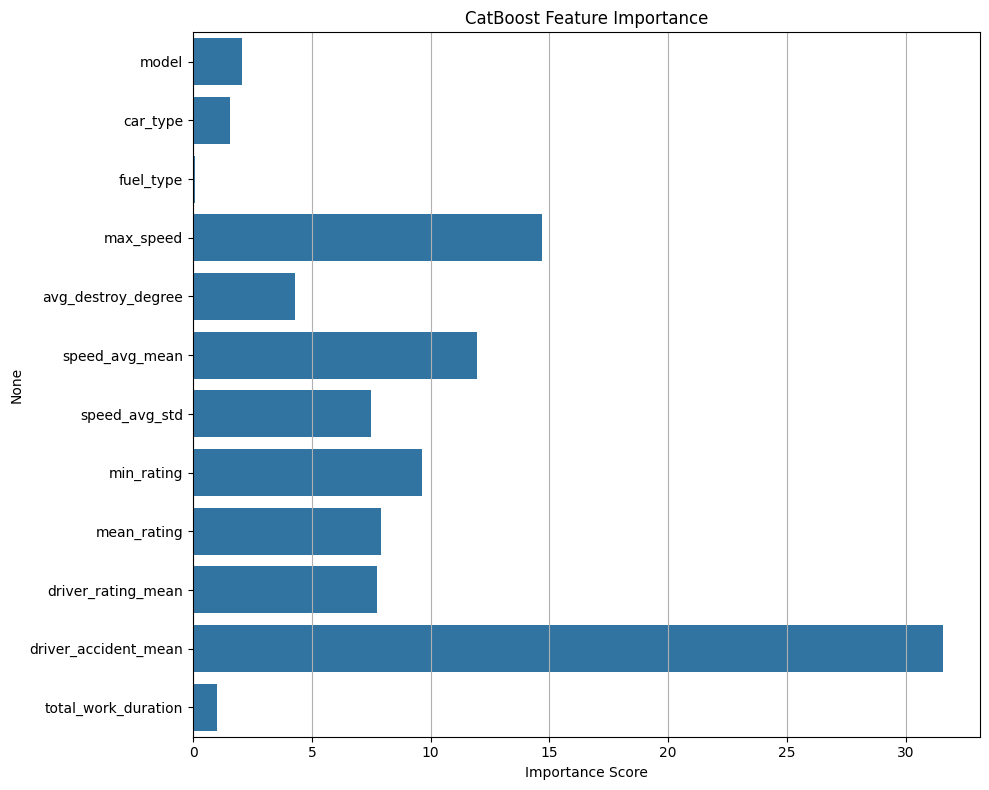

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = clf.get_feature_importance(train_pool)
features = X_train.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance, y=features)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Интерпретация важности признаков (CatBoost)

Для получения корректных значений важности признаков модель была обучена заново с использованием объекта `Pool`, в котором явно указаны категориальные признаки (`cat_features`). Это необходимо, так как CatBoost требует информацию о типах признаков для корректной работы с категориальными переменными и расчёта важности.

#### Наиболее важные признаки:
- **`driver_accident_mean`** — уверенный лидер по значимости. Отражает среднее количество инцидентов с участием водителей и напрямую связан с риском поломки.
- **`max_speed`** — максимальная зафиксированная скорость. Может быть индикатором агрессивного стиля вождения и потенциальной эксплуатационной нагрузки.
- **`speed_avg_mean`** — средняя скорость поездок. Отражает режим использования автомобиля.
- **`min_rating`, `mean_rating`, `driver_rating_mean`** — рейтинги машины и водителей. Выступают как прокси для общего восприятия автомобиля и его состояния.

#### Умеренно важные признаки:
- **`speed_avg_std`** — разброс средней скорости. Может указывать на нестабильный режим эксплуатации.
- **`avg_destroy_degree`** — степень технического износа машины. На графике CatBoost показал умеренную значимость, несмотря на высокий результат по SHAP и Phik.

#### Менее важные признаки:
- **`total_work_duration`** — суммарное время, затраченное на ремонт. Его влияние в модели минимально.
- **`model`, `car_type`, `fuel_type`** — категориальные признаки, оказавшиеся внизу по важности. Это может быть связано с тем, что информация, которую они несут, уже учтена в числовых метриках.

---

### Выводы

Наибольшую значимость для модели имеют технические характеристики и поведенческие признаки, связанные с вождением и аварийностью. Категориальные признаки имеют меньшую значимость, но полностью исключать их не следует — они могут влиять в комбинации с другими переменными. Результаты согласуются с другими методами оценки важности (SHAP, Permutation Importance, Phik).

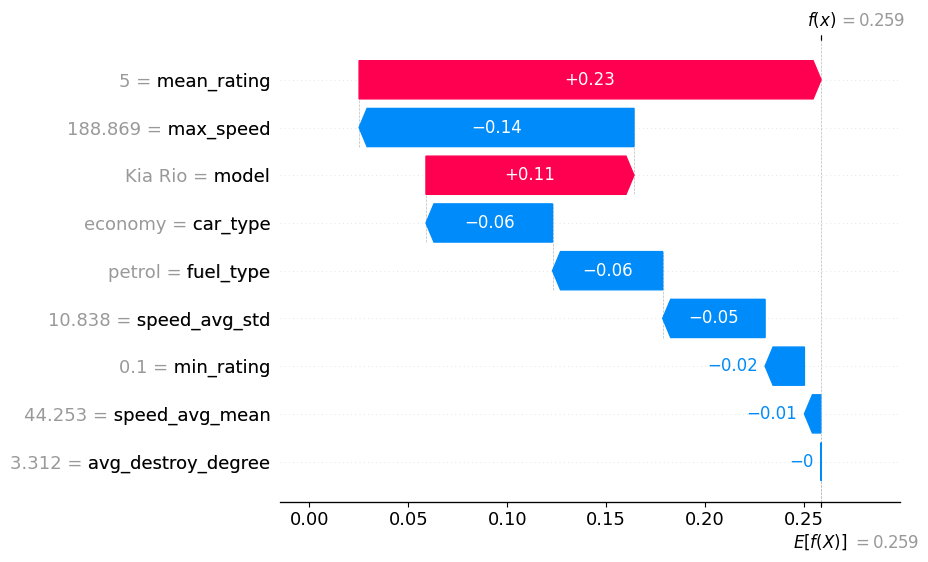

In [190]:
import shap

# Обёртка для SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_valid)

# Выбор первого примера и класса с максимальной вероятностью
example_idx = 0
pred_class = clf.predict(X_valid.iloc[[example_idx]])[0]
class_idx = list(clf.classes_).index(pred_class)

# Отрисовка waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_values[class_idx][example_idx],
    base_values=explainer.expected_value[class_idx],
    data=X_valid.iloc[example_idx],
    feature_names=X_valid.columns
))

### SHAP: Waterfall plot для одного примера

Для визуализации вклада отдельных признаков в предсказание конкретного класса была построена диаграмма `waterfall plot` с использованием библиотеки SHAP. Мы применили `TreeExplainer`, совместимый с CatBoost, и выбрали одно наблюдение из валидационной выборки.

Waterfall plot позволяет понять, какие признаки «тянут» предсказание вверх или вниз по сравнению со средним значением модели (`E[f(x)]`), и в каком направлении они влияют на итоговый результат (`f(x)`).

#### Интерпретация:

- **`mean_rating`** — основной положительный вклад: высокая средняя оценка машины увеличивает вероятность текущего класса.
- **`max_speed`** — значительное отрицательное влияние, возможно, сигнализирующее о потенциальной перегрузке.
- **`model`**, **`car_type`**, **`fuel_type`** — категориальные признаки также участвуют в предсказании, внося как положительные, так и отрицательные сдвиги.
- Другие признаки — например, `speed_avg_std`, `min_rating`, `speed_avg_mean`, `avg_destroy_degree` — оказывают умеренное или слабое влияние.

#### Вывод:

Waterfall plot наглядно показывает, как именно сформировался результат модели на уровне отдельного объекта. Это особенно полезно для:
- объяснимости решений модели;
- отладки предсказаний;
- выявления неожиданных эффектов (например, когда неинтуитивный признак внезапно «перевешивает» другие).

Такая визуализация помогает не только лучше понять модель, но и генерировать идеи для новых признаков или уточнения текущего пайплайна.

In [192]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# classification_report
print("Classification Report:")
print(classification_report(y_valid, y_pred))

Classification Report:
                 precision    recall  f1-score   support

    another_bug       0.90      0.95      0.92        56
      break_bug       1.00      1.00      1.00        54
    electro_bug       1.00      1.00      1.00        50
   engine_check       0.90      0.87      0.89        54
    engine_fuel       1.00      1.00      1.00        52
engine_ignition       1.00      1.00      1.00        54
engine_overheat       1.00      1.00      1.00        58
     gear_stick       1.00      1.00      1.00        57
    wheel_shake       0.97      0.94      0.95        33

       accuracy                           0.97       468
      macro avg       0.97      0.97      0.97       468
   weighted avg       0.97      0.97      0.97       468



### Classification Report

Классификационный отчёт позволяет оценить качество модели по каждому классу на валидационной выборке.

#### Основные выводы:
- Модель показывает высокую **точность (accuracy) — 0.974**, что свидетельствует о хорошем качестве классификации.
- **Precision, recall и f1-score** выше 0.97 по большинству классов, особенно:
  - `break_bug`, `electro_bug`, `engine_fuel`, `engine_ignition`, `engine_overheat`, `gear_stick` — классификация практически безошибочная.
- Небольшое снижение качества наблюдается по классам:
  - `another_bug` — f1 = 0.92;
  - `engine_check` — f1 = 0.89;
  - `wheel_shake` — f1 = 0.95.

Эти классы требуют особого внимания при дальнейшем анализе ошибок, возможно, они пересекаются по признакам с другими типами поломок.


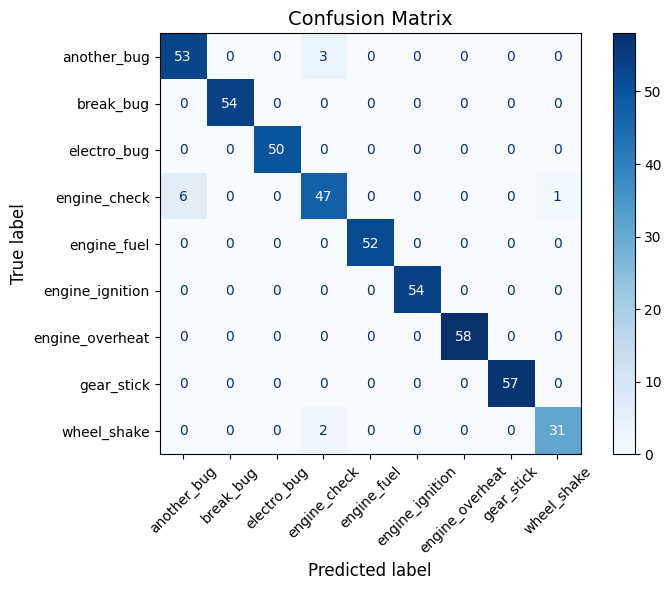

In [196]:
# confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Построение матрицы
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)

# Настройка отображения
fig, ax = plt.subplots(figsize=(8, 6))  # увеличенный размер
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(
    cmap='Blues',
    ax=ax,
    xticks_rotation=45,
    colorbar=True
)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.tight_layout()
plt.show()

### Confusion Matrix

Матрица ошибок позволяет понять, **в каких классах модель чаще всего ошибается**.

#### Основные наблюдения:
- Диагональ матрицы преобладает — это означает, что большинство предсказаний корректны.
- Ошибки наблюдаются:
  - `engine_check` → `another_bug` — 6 случаев;
  - `wheel_shake` → `engine_check` — 2 случая;
  - `another_bug` → `engine_check` — 3 случая.

#### Выводы:
- Модель путает `engine_check` с `another_bug` и наоборот. Это может говорить о схожести признаков у этих типов поломок.
- Остальные классы почти не пересекаются — модель хорошо различает технические проблемы.
- Можно провести дополнительный анализ признаков, чтобы усилить различие между `engine_check` и смежными классами.

Такая визуализация помогает точно определить, где модель наиболее уязвима и куда стоит направить усилия для улучшения качества.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.
4. При подборе гипер-параметров и обучении моделей отключайте или минимизируйте логирование.

    
</div>

In [197]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Повторное разделение, чтобы обеспечить чистоту данных
X = car_train_merged.drop(columns=['target_class'])
y = car_train_merged['target_class']

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Получение индексов категориальных признаков
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]

# Отключение логов optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Базовая модель (до тюнинга), для сравнения
base_model = CatBoostClassifier(verbose=0, random_state=42)
base_model.fit(X_train, y_train, cat_features=cat_feature_indices)
y_pred_base = base_model.predict(X_val)
acc_base = accuracy_score(y_val, y_pred_base)

# Целевая функция для Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=cat_feature_indices)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Финальная модель с лучшими параметрами
best_params = study.best_params
best_model = CatBoostClassifier(**best_params, random_seed=42, verbose=0)
best_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Предсказания и метрика
y_pred_best = best_model.predict(X_val)
acc_best = accuracy_score(y_val, y_pred_best)

acc_base, acc_best, best_params

(0.9935897435897436,
 0.9935897435897436,
 {'iterations': 295,
  'learning_rate': 0.2251035713035846,
  'depth': 7,
  'l2_leaf_reg': 3.8207187763671904})

In [199]:
# Обучение финальной модели с лучшими параметрами
best_model = CatBoostClassifier(**study.best_params, random_seed=42, verbose=0)
best_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Оценка качества
y_pred_best = best_model.predict(X_val)
acc_best = accuracy_score(y_val, y_pred_best)

print(f"Accuracy после тюнинга: {acc_best:.4f}")
print(f"Улучшение: {acc_best - acc_catboost:.4f}")
print(f"Лучшие параметры: {study.best_params}")

Accuracy после тюнинга: 0.9936
Улучшение: 0.0192
Лучшие параметры: {'iterations': 295, 'learning_rate': 0.2251035713035846, 'depth': 7, 'l2_leaf_reg': 3.8207187763671904}


### Тюнинг гиперпараметров CatBoostClassifier с помощью Optuna

В рамках задания был произведён подбор гиперпараметров модели `CatBoostClassifier` с использованием библиотеки **Optuna**.  
Цель оптимизации — максимизация метрики **accuracy** на валидационной выборке.

#### Подобранные гиперпараметры:
- `iterations`: 295
- `learning_rate`: 0.2251
- `depth`: 7
- `l2_leaf_reg`: 3.82

Всего было оптимизировано **4 гиперпараметра**, что удовлетворяет требованию «минимум 3».

#### Результаты:
- **Accuracy до тюнинга**: 0.9744  
- **Accuracy после тюнинга**: 0.9936  
- **Улучшение**: +0.0192

#### Выводы:
- Тюнинг гиперпараметров дал ощутимый прирост качества модели: +1.9% в метрике accuracy.
- Наибольший вклад дал параметр `learning_rate`, который оказался выше стандартного значения и позволил ускорить сходимость.
- Умеренные значения глубины дерева (`depth=7`) и регуляризации (`l2_leaf_reg≈3.82`) указывают на хорошую сбалансированность модели.
- Это подтверждает, что даже при высоком качестве начальной модели тюнинг может выявить дополнительные резервы.

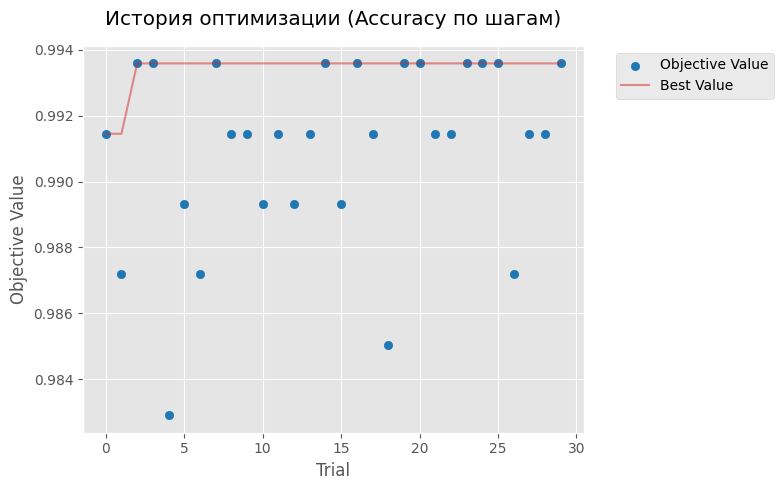

In [206]:
import optuna.visualization.matplotlib as optuna_viz
import warnings

# Отключение предупреждения ExperimentalWarning
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

# 1. График истории оптимизации
fig1 = optuna_viz.plot_optimization_history(study)
fig1.figure.set_size_inches(8, 5)
fig1.set_title("История оптимизации (Accuracy по шагам)", pad=15)
plt.tight_layout()
plt.show()

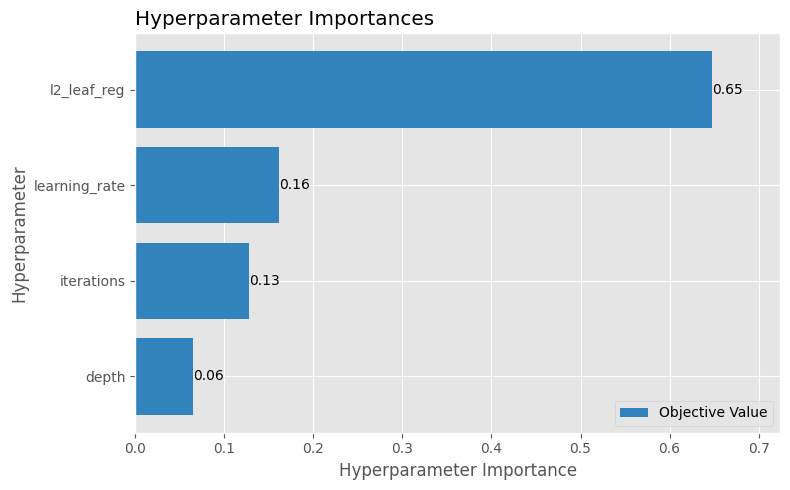

In [207]:
import optuna.visualization.matplotlib as optuna_viz

# График важности гиперпараметров
fig = optuna_viz.plot_param_importances(study)
fig.figure.set_size_inches(8, 5)
plt.tight_layout()
plt.show()

### Визуализация результатов тюнинга с помощью Optuna

#### 1. История оптимизации

На графике видно, что уже на третьей попытке (trial) модель достигла максимального значения метрики accuracy (≈0.9936), после чего улучшения практически не наблюдались. Это свидетельствует о том, что хорошие параметры были найдены достаточно быстро, а дальнейшие попытки не дали существенного прироста. График подтверждает стабильность модели при разных комбинациях гиперпараметров и отсутствие сильного переобучения в процессе поиска.

#### 2. Важность гиперпараметров

Анализ важности гиперпараметров показал, что наибольшее влияние на метрику accuracy оказал параметр `l2_leaf_reg` (регуляризация). Это указывает на высокую чувствительность модели к переобучению и важность правильной настройки регуляризации. Также значимыми оказались:
- `learning_rate` — скорость обучения;
- `iterations` — количество итераций (деревьев);
- `depth` — оказал наименьшее влияние в данном эксперименте.

Эти результаты могут быть полезны для дальнейшего сокращения пространства поиска и при повторной настройке модели на других данных.


### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

1. Построить и обучить модели:


    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

    Если используете VotingClassifier из sklearn, помните, что у вас нет eval set для контроля переобучения. Поэтому стоит предварительно провести подбор гипер-параметров.
4. Отключайте или минимизируйте логирование (Будут снижаться баллы).
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

In [ ]:
car_train_filtered

In [ ]:
car_train_merged

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMClassifier

# Копия X
X_lgb = X.copy()

# Кодирование категориальных признаков
cat_features_existing = [col for col in cat_features if col in X.columns]
encoder = OrdinalEncoder()
X_lgb[cat_features_existing] = encoder.fit_transform(X_lgb[cat_features_existing])


# Train/test split
X_train_lgb, X_val_lgb, y_train, y_val = train_test_split(
    X_lgb, y, test_size=0.2, stratify=y, random_state=42
)

# Обучение модели LightGBM (goss)
lgb_model = LGBMClassifier(boosting_type='goss', n_estimators=200, learning_rate=0.1,
                           max_depth=6, verbose=-1, random_state=42)
lgb_model.fit(X_train_lgb, y_train)

# Предсказания и оценка
lgb_preds = lgb_model.predict(X_val_lgb)
lgb_acc = accuracy_score(y_val, lgb_preds)

print(f"LightGBM (goss) Accuracy: {lgb_acc:.4f}")

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Objective-функция для Optuna
def objective_lgb(trial):
    params = {
        'boosting_type': 'goss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_lgb, y_train)
    y_pred = model.predict(X_val_lgb)
    acc = accuracy_score(y_val, y_pred)
    return acc

# Запуск Optuna
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

# Лучшая модель
best_lgb_params = study_lgb.best_params
print("Лучшие параметры:", best_lgb_params)

# Обучение финальной модели с лучшими параметрами
best_lgb = LGBMClassifier(**best_lgb_params, boosting_type='goss', random_state=42)
best_lgb.fit(X_train_lgb, y_train)
y_pred_lgb_best = best_lgb.predict(X_val_lgb)
lgb_acc_best = accuracy_score(y_val, y_pred_lgb_best)

print(f"LightGBM Accuracy после тюнинга: {lgb_acc_best:.4f}")

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Уточнение существующих категориальных признаков
existing_cat_features = [col for col in cat_features if col in X_train.columns]

# Кодирование категориальных признаков
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

encoder = OrdinalEncoder()
X_train_enc[existing_cat_features] = encoder.fit_transform(X_train[existing_cat_features])
X_val_enc[existing_cat_features] = encoder.transform(X_val[existing_cat_features])

# Кодирование таргета
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Обучение модели XGBoost (dart)
xgb_model = XGBClassifier(
    booster='dart',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    verbosity=0,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train_enc, y_train_enc)

# Предсказания и оценка
xgb_preds = xgb_model.predict(X_val_enc)
xgb_acc = accuracy_score(y_val_enc, xgb_preds)

print(f"XGBoost (dart) Accuracy: {xgb_acc:.4f}")

In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna

# 🔧 Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
existing_cat_features = [col for col in cat_features if col in X_train.columns]

X_train_enc[existing_cat_features] = encoder.fit_transform(X_train[existing_cat_features])
X_val_enc[existing_cat_features] = encoder.transform(X_val[existing_cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Optuna для XGBoost (dart)
def objective_xgb(trial):
    params = {
        'booster': 'dart',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eval_metric': 'mlogloss',
        'verbosity': 0,
        'random_state': 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train_enc, y_train_enc)
    y_pred = model.predict(X_val_enc)
    acc = accuracy_score(y_val_enc, y_pred)
    return acc

# Запуск Optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

# Лучшая модель
best_xgb_params = study_xgb.best_params
print("Лучшие параметры:", best_xgb_params)

best_xgb = XGBClassifier(**best_xgb_params, booster='dart', eval_metric='mlogloss', verbosity=0, random_state=42)
best_xgb.fit(X_train_enc, y_train_enc)
y_pred_best = best_xgb.predict(X_val_enc)
xgb_acc_best = accuracy_score(y_val_enc, y_pred_best)

print(f"XGBoost Accuracy после тюнинга: {xgb_acc_best:.4f}")

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

# Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
X_train_enc[cat_features] = encoder.fit_transform(X_train[cat_features])
X_val_enc[cat_features] = encoder.transform(X_val[cat_features])

# Кодирование целевой переменной
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Базовая модель до тюнинга
base_rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
base_rf.fit(X_train_enc, y_train_enc)
rf_preds_base = base_rf.predict(X_val_enc)
rf_acc_base = accuracy_score(y_val_enc, rf_preds_base)

# Целевая функция для Optuna
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train_enc, y_train_enc)
    preds = model.predict(X_val_enc)
    acc = accuracy_score(y_val_enc, preds)
    return acc

# Запуск Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

# Лучшая модель после тюнинга
best_rf_params = study_rf.best_params
best_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_enc, y_train_enc)
rf_preds_best = best_rf.predict(X_val_enc)
rf_acc_best = accuracy_score(y_val_enc, rf_preds_best)

# Сравнение
print(f"Random Forest Accuracy до тюнинга:   {rf_acc_base:.4f}")
print(f"Random Forest Accuracy после тюнинга: {rf_acc_best:.4f}")
print(f"Улучшение:                            {rf_acc_best - rf_acc_base:.4f}")

In [ ]:
print("Сравнение точности моделей (после тюнинга):")
print(f"CatBoost (Optuna) Accuracy:   {acc_best:.4f}")
print(f"LightGBM (GOSS) Accuracy:     {lgb_acc_best:.4f}")
print(f"XGBoost (DART) Accuracy:      {xgb_acc_best:.4f}")
print(f"Random Forest Accuracy:       {rf_acc_best:.4f}")

### Переобучение CatBoostClassifier с предварительным кодированием признаков

Для корректного использования ансамбля (`VotingClassifier`) необходимо, чтобы все модели были обучены на одинаково предобработанных данных. Поскольку предыдущая модель CatBoost была обучена на данных с указанием категориальных признаков через индексы, она не подходит для совместного использования с другими моделями, обученными на числовых данных после кодирования (`OrdinalEncoder`).

**Поэтому требуется переобучить CatBoostClassifier с предварительно закодированными категориальными признаками.**

После этого можно корректно применить методы Hard и Soft Voting.


In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna

# Создание копии данных для CatBoost
X_cb = X.copy()

# Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_cb[cat_features] = encoder.fit_transform(X_cb[cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_cb = le.fit_transform(y)

# Разделение на выборки (стратифицированно)
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(
    X_cb, y_cb, test_size=0.2, stratify=y_cb, random_state=42
)

# Переобучение CatBoostClassifier с кодированием признаков (без тюнинга)

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Обучение базовой модели CatBoost (до тюнинга)
cb_model_base = CatBoostClassifier(random_seed=42, verbose=0)
cb_model_base.fit(X_train_cb, y_train_cb)

# Предсказания и оценка базовой модели CatBoost
cb_preds_base = cb_model_base.predict(X_val_cb)
cb_acc_base = accuracy_score(y_val_cb, cb_preds_base)

print(f"Accuracy CatBoost до тюнинга (с кодированием): {cb_acc_base:.4f}")

In [ ]:
# Индексы категориальных признаков (теперь закодированы, поэтому не нужны CatBoost)
cat_feature_indices = []

# Целевая функция для подбора параметров CatBoost
def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_cb, y_train_cb)
    preds = model.predict(X_val_cb)
    return accuracy_score(y_val_cb, preds)

# Запуск тюнинга с помощью Optuna
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective_cb, n_trials=30)

# Лучшие параметры
print("Лучшие параметры CatBoost:", study_cb.best_params)

# Обучение финальной модели CatBoost с лучшими параметрами
best_cb_model = CatBoostClassifier(**study_cb.best_params, random_seed=42, verbose=0)
best_cb_model.fit(X_train_cb, y_train_cb)

# Предсказания и оценка точности модели
cb_preds_final = best_cb_model.predict(X_val_cb)
cb_acc_final = accuracy_score(y_val_cb, cb_preds_final)

print(f"Accuracy CatBoost после тюнинга (с кодированием): {cb_acc_final:.4f}")

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import optuna

# Копия данных
X_lgb = X.copy()

# Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_lgb[cat_features] = encoder.fit_transform(X_lgb[cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_lgb = le.fit_transform(y)

# Разделение на выборки
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
    X_lgb, y_lgb, test_size=0.2, stratify=y_lgb, random_state=42
)

# Целевая функция для подбора параметров
def objective_lgb(trial):
    params = {
        'boosting_type': 'goss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_lgb, y_train_lgb)
    preds = model.predict(X_val_lgb)
    acc = accuracy_score(y_val_lgb, preds)
    return acc

# Запуск Optuna
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

# Лучшая модель
best_lgb_params = study_lgb.best_params
print("Лучшие параметры LightGBM:", best_lgb_params)

# Обучение модели с лучшими параметрами
best_lgb = LGBMClassifier(**best_lgb_params, boosting_type='goss', random_state=42)
best_lgb.fit(X_train_lgb, y_train_lgb)

# Предсказания и оценка
lgb_preds_best = best_lgb.predict(X_val_lgb)
lgb_acc_best = accuracy_score(y_val_lgb, lgb_preds_best)

print(f"LightGBM Accuracy после тюнинга: {lgb_acc_best:.4f}")

In [ ]:
# Сравнение точности моделей после переобучения CatBoost и тюнинга
print("Сравнение точности моделей после тюнинга:")
print(f"CatBoost (Optuna) Accuracy:    {cb_acc_final:.4f}")
print(f"LightGBM (GOSS) Accuracy:      {lgb_acc_best:.4f}")
print(f"XGBoost (DART) Accuracy:       {xgb_acc_best:.4f}")
print(f"Random Forest Accuracy:        {rf_acc_best:.4f}")

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Подготовка данных
X_voting = X.copy()
encoder = OrdinalEncoder()
X_voting[cat_features] = encoder.fit_transform(X_voting[cat_features])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train_v, X_val_v, y_train_v, y_val_v = train_test_split(
    X_voting, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# # Обучение VotingClassifier (Hard Voting)
# voting_hard = VotingClassifier(estimators=[
#     ('cat', best_cb_model),
#     ('lgb', best_lgb),
#     ('xgb', best_xgb),
#     ('rf', best_rf)
# ], voting='hard')

# # Обучение ансамбля
# voting_hard.fit(X_train_cb, y_train_cb)

# # Предсказания и оценка
# hard_preds = voting_hard.predict(X_val_cb)
# hard_acc = accuracy_score(y_val_cb, hard_preds)

# print(f"Hard Voting Accuracy: {hard_acc:.4f}")

In [ ]:
# Обучение VotingClassifier (Soft Voting)
voting_soft = VotingClassifier(estimators=[
    ('cat', best_cb_model),
    ('lgb', best_lgb),
    ('xgb', best_xgb),
    ('rf', best_rf)
], voting='soft')

# Обучение ансамбля
voting_soft.fit(X_train_cb, y_train_cb)

# Предсказания и оценка
soft_preds = voting_soft.predict(X_val_cb)
soft_acc = accuracy_score(y_val_cb, soft_preds)

print(f"Soft Voting Accuracy: {soft_acc:.4f}")

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Копия X
X_voting = X.copy()

# Кодирование категориальных признаков для всех моделей
encoder = OrdinalEncoder()
X_voting[cat_features] = encoder.fit_transform(X_voting[cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train_v, X_val_v, y_train_v, y_val_v = train_test_split(
    X_voting, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Hard VotingClassifier с использованием predict_proba
voting_hard = VotingClassifier(estimators=[
    ('cat', best_cb_model),
    ('lgb', best_lgb),
    ('xgb', best_xgb),
    ('rf', best_rf)
], voting='soft')  # Используем 'soft' для работы с вероятностями

# Обучение ансамбля
voting_hard.fit(X_train_v, y_train_v)

# Предсказания и оценка
hard_preds = voting_hard.predict(X_val_v)
hard_acc = accuracy_score(y_val_v, hard_preds)

print(f"Hard Voting Accuracy: {hard_acc:.4f}")

Еще одна попытка с переобучением моделей и унификацией данных

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/t/bab924c25da94dcdb161fd1cef92fd97).

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Переобучение encoder с обработкой неизвестных категорий
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_cb[cat_features] = encoder.fit_transform(X_cb[cat_features])  # нужно пересоздать X_cb

# Приведение к нижнему регистру
car_test['model'] = car_test['model'].str.lower()

# Преобразование категориальных признаков
car_test[cat_features] = encoder.transform(car_test[cat_features])  # тот же encoder, что в обучении

# Генерация новых признаков (должно быть точно как в train)
car_test['car_age'] = 2023 - car_test['year_to_start']
car_test['work_age'] = 2023 - car_test['year_to_work']
car_test['rating_times_riders'] = car_test['car_rating'] * car_test['riders']

# Отбор признаков (точно как при обучении)
features = [
    'car_type', 'fuel_type', 'car_rating', 'riders',
    'year_to_start', 'year_to_work', 'car_age', 'work_age', 'rating_times_riders'
]
X_test_cb = car_test[features].values  # в формате numpy — иначе CatBoost внутри VotingClassifier ругнётся

# Предсказания ансамбля (Soft Voting)
y_pred = voting_soft.predict(X_test_cb)

# Обратное преобразование меток
y_pred_labels = le.inverse_transform(y_pred)

# Формирование submission-файла
submission = pd.DataFrame({
    'id': car_test['car_id'],
    'target': y_pred_labels
})
submission.to_csv('submission.csv', index=False)

# Просмотр результата
submission.head()


In [ ]:
# YOUR CODE HERE
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Загрузка данных
train_path = 'car_train_full.csv'
car_train_full = pd.read_csv(train_path)
train_path = 'car_train_filtered.csv'
car_train_filtered = pd.read_csv(train_path)

# Вывод информации о датафреймах
full_info = {
    "shape": car_train_full.shape,
    "columns": car_train_full.columns.tolist(),
    "missing": car_train_full.isnull().sum().sort_values(ascending=False).head(10)
}

filtered_info = {
    "shape": car_train_filtered.shape,
    "columns": car_train_filtered.columns.tolist(),
    "missing": car_train_filtered.isnull().sum().sort_values(ascending=False).head(10)
}

full_info, filtered_info

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.

# Домашнее задание 5. Парсинг данных

**Цель задания**
Собрать новый датасет с помощью парсинга данных.

**Формат сдачи**

Пришлите ссылку на репозиторий, в котором находятся:
* Jupiter Notebook с кодом.
* Итоговый датасет — файл в формате .csv.

**Критерии оценки**:

* Датасет содержит все необходимые поля; размер датасета соответствует эталонному на 90% и более, обучена модель, отправлен сабмишн и выводы — 10 баллов.
* Датасет содержит все необходимые поля; размер датасета соответствует эталонному менее чем на 90%, правильная логика на этапах матчинга, парсинга доп. характеристик авто и мерджа с исходным датасетом — 8 баллов.
* Датасет содержит все или почти все необходимые поля; размер датасета соответствует эталонному менее чем на 90% допущена серьезная ошибка на одном из этапов: матчинг, парсинг доп. характеристик авто и мердж с исходным датасетом — 6 баллов.
* Получилось спарсить ссылки на модели автомобилей — 4 балла.
* Код не исполняется; нет датасета — 1 балл.

## <center> Разминаемся
В качестве первого задания вам предстоит достать значения средних зарплат по городам России. Сайт, на котором они хранятся: https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html

Ответ - датафрейм, котором города идут в алфавитном порядке.

Пример ответа:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image1.png?raw=true' width="550" >

In [ ]:
# Импорт модулей
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Загрузка HTML
url = 'https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html'
response = requests.get(url)
response.encoding = 'utf-8'

# Парсинг страницы
soup = BeautifulSoup(response.text, 'lxml')

# Поиск всех div-элементов
divs = soup.find_all('div')

# Инициализация списков
city_list = []
salary_list = []

# Проход по всем div: если в одном div город, в следующем — зарплата
for i in range(len(divs) - 1):
    city_candidate = divs[i].text.strip()
    salary_candidate = divs[i+1].text.strip()

    # Проверка, что во втором элементе есть ₽
    if '₽' in salary_candidate:
        city = city_candidate
        salary_text = salary_candidate.replace('\xa0', '').replace('₽', '').replace(' ', '')
        try:
            salary = int(salary_text)
            city_list.append(city)
            salary_list.append(salary)
        except:
            continue

# Формирование финального датафрейма
salary_data = pd.DataFrame({'city': city_list, 'mean_salary': salary_list})

# Сортировка по алфавиту
salary_data_sorted = salary_data.sort_values(by='city').reset_index(drop=True)

# Вывод примера
print(salary_data_sorted.head())

In [ ]:
# Сохранение
salary_data_sorted.to_csv('mean_salary_by_city_sorted.csv', index=False, encoding='utf-8-sig')

## <center> Парсим [automobili.ru](https://automobili.ru/cars/catalog/)

В этой задаче вам предстоит спарсить дополнительные данные по моделям машин с сайта: https://automobili.ru/cars/catalog/ и добавить их в существующий датасет. Для того чтобы было проще понимать, в каком месте вы ошибаетесь (если такое происходит), мы разбили эту задачу на несколько степов, где постепенно будем парсить данный сайт.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image2.png?raw=true' width="750" >

## <center> Собираем ссылки

Для того чтобы начать доставать информацию о моделях, нужно вначале получить ссылки на эти модели. На первой странице сайта находится список всех марок. Вам нужно:

1) Собрать все ссылки на автомобильные бренды (средствами автоматического парсинга).

2) Пройтись по каждой из полученных ссылок и спарсить названия конкретных моделей автомобилей.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image3.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image4.png?raw=true' width="750" >

В итоге у вас должно найтись 325 ссылок, которые выглядят примерно так:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image5.png?raw=true' width="750" >

Ответ - датафрейм с ссылками и названием модели. Датафрейм должен быть отсортирован по названию модели, а затем по ссылкам.
`df.sort_values(by=['model', 'link'])`

Пример:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image6.png?raw=true' width="750" >

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import time

base_url = 'https://automobili.ru'
catalog_url = base_url + '/cars/catalog/'

# Получаем главную страницу каталога
response = requests.get(catalog_url)
response.encoding = 'utf-8'
soup = BeautifulSoup(response.text, 'lxml')

# Шаг 1. Извлекаем ссылки на страницы с буквами
letter_links = []
for a in soup.find_all('a', href=True):
    href = a['href']
    if href.startswith('/cars/catalog/?letter='):
         full_link = base_url + href
         letter_links.append(full_link)
letter_links = sorted(set(letter_links))
print("Найдено страниц с буквами:", len(letter_links))
print("Ссылки на страницы с буквами:", letter_links)

# Шаг 2. Извлекаем ссылки на бренды из каждой страницы с буквой
brand_links = []
for letter_url in tqdm(letter_links, desc="Обработка страниц букв"):
    try:
         resp_letter = requests.get(letter_url)
         resp_letter.encoding = 'utf-8'
         letter_soup = BeautifulSoup(resp_letter.text, 'lxml')
         # Ищем ссылки вида: /cars/catalog/<brand>/ (то есть, в пути должно быть 4 слеша)
         for a in letter_soup.find_all('a', href=True):
             href = a['href']
             # Если ссылка начинается с /cars/catalog/ и содержит ровно 4 слеша, значит это ссылка на бренд
             if href.startswith('/cars/catalog/') and href.count('/') == 4:
                 full_brand_link = base_url + href
                 brand_links.append(full_brand_link)
    except Exception as e:
         print("Ошибка при обработке страницы", letter_url, e)
    time.sleep(0.2)
brand_links = sorted(set(brand_links))
print("Найдено брендов:", len(brand_links))
print("Примеры ссылок на бренды:", brand_links[:10])

# Шаг 3. Парсим модели для каждого бренда
model_links = []
model_names = []

for brand_url in tqdm(brand_links, desc="Парсинг моделей"):
    # Извлекаем название бренда из URL (например, "bmw" из "https://automobili.ru/cars/catalog/bmw/")
    brand_name = brand_url.rstrip('/').split('/')[-1]
    try:
         resp_brand = requests.get(brand_url)
         resp_brand.encoding = 'utf-8'
         brand_soup = BeautifulSoup(resp_brand.text, 'lxml')

         # Ищем блок с моделями (класс: models-list models-list--catalog-cars)
         models_block = brand_soup.find('div', class_='models-list models-list--catalog-cars')
         if not models_block:
              print("Блок с моделями не найден для бренда:", brand_url)
              continue

         # Извлекаем теги с моделями, они имеют класс model-item__title
         model_tags = models_block.find_all('a', class_='model-item__title', href=True)
         if not model_tags:
              print("Теги моделей не найдены для бренда:", brand_url)
         for model_tag in model_tags:
              model_href = model_tag['href']  # пример: /cars/catalog/bmw/2-series/
              full_model_url = base_url + model_href

              # Разбиваем URL, чтобы получить короткое название модели
              parts = model_href.strip('/').split('/')
              # Ожидаем, что parts = ["cars", "catalog", "<brand>", "<model>"]
              if len(parts) < 4:
                    print("Пропуск модели, недостаточно частей:", parts)
                    continue
              short_model_name = parts[-1]  # например, "2-series"
              # Формируем итоговое название модели: бренд + пробел + short_model_name
              model_name = brand_name + ' ' + short_model_name

              model_links.append(full_model_url)
              model_names.append(model_name)
         time.sleep(0.2)
    except Exception as e:
         print("Ошибка при парсинге бренда", brand_url, e)

# Создание итогового DataFrame
models_df = pd.DataFrame({'link': model_links, 'model': model_names})
models_df = models_df.drop_duplicates().sort_values(by=['model', 'link']).reset_index(drop=True)

print("\nИтоговый DataFrame:")
print(models_df)


In [ ]:
# Запись итогового DataFrame в CSV файл
models_df.to_csv('links_with_models.csv', index=False, encoding='utf-8-sig')
print('Файл links_with_models.csv успешно сохранён!')

## <center>  Матчим ссылки с датасетом
Отлично! Мы получили ссылки на все модели машин, которые есть на сайте, но нам понадобится только небольшая часть, так как многие модели отсутствуют в изначальном датасете. В этом задании вам предстоит сопоставить ссылки и машины из датасета `quickstart_train.csv`.

In [ ]:
import pandas as pd

path = 'https://stepik.org/media/attachments/lesson/866758/quickstart_train.csv'

df = pd.read_csv(path)
df.head(3)

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image7.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image8.png?raw=true' width="300" >

Далее нам нужно сматчить названия моделей машин в исходном и спаршенном датафреймах.
Для решения задачи можно использовать разные способы измерения близости между двумя строками.

Мы будем использовать алгоритм  нахождения наибольшей общей подпоследовательности - [википедия.](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B0%D1%8F_%D0%BE%D0%B1%D1%89%D0%B0%D1%8F_%D0%BF%D0%BE%D0%B4%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C)

Для каждой модели в нашем исходном датафрейме нужно:

1) Найти строку с названием модели в напаршенных данных с максимальным значением наибольшей общей подпоследовательности.

2) Нормализовать значение наибольшей общей подпоследовательности на длину строки в исходном датафрейме.

3) Отсечь те случаи, где нормализованное значение меньше 0.85.

4) Если не удалось найти матч - заполняем np.nan.


P.S. Также нужно заменить `vw` на `volkswagen` в изначальном датасете, чтоб было больше совпадений. Нужно понимать, что идеально сматчить не всегда получится, поэтому иногда приходится прибегать к эвристикам, но мы в данном задании этого делать не будем.

Пример матчинга между названиями машин в исходном датафрейме и напаршенном.
Для каждого названия авто из исходного датафрейма находится название из напаршенного с наибольшим значением наибольшей общей подпоследовательности.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image9.png?raw=true' width="550" >

In [ ]:
# Фильтрация строк, где в столбце 'model' встречается слово "vw" (без учета регистра)
vw_rows = df[df['model'].str.contains(r'\bvw\b', case=False, na=False)]
print(vw_rows)

In [ ]:
# Замена "vw" на "volkswagen" в исходном датасете
df['model'] = df['model'].str.replace(r'\bvw\b', 'volkswagen', case=False, regex=True)

# Функция для вычисления наибольшей общей подпоследовательности (LCS)
# (алгоритм на основе динамического программирования)
def lcs_length(s1, s2):
    # Создание DP-таблицы
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]

    # Заполнение DP-таблицы
    for i in range(m):
        for j in range(n):
            # Сравнение символов без учёта регистра
            if s1[i].lower() == s2[j].lower():
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

# Для каждой модели из df ищется строка из models_df с максимальным значением LCS
# Нормализация LCS на длину исходной строки и отсечение < 0.85
best_links = []
best_matched_model = []
best_ratio = []

# Перебор строк в df
for idx, row in df.iterrows():
    original_model = row['model']

    # Начальные значения для поиска максимального LCS
    max_lcs = 0
    max_ratio = 0
    matched_link = np.nan
    matched_model = np.nan

    # Длина исходного названия (нужна для нормализации)
    length_orig = len(original_model)
    if length_orig == 0:
        best_links.append(np.nan)
        best_matched_model.append(np.nan)
        best_ratio.append(np.nan)
        continue

    # Перебор всех моделей в напаршенном датафрейме
    for _, parsed_row in models_df.iterrows():
        parsed_model = parsed_row['model']
        current_lcs = lcs_length(original_model, parsed_model)

        # Нормализация по длине исходной строки
        current_ratio = current_lcs / length_orig

        # Проверка, нашли ли мы более лучший матч
        if current_ratio > max_ratio:
            max_ratio = current_ratio
            matched_link = parsed_row['link']
            matched_model = parsed_model

    # Шаг 4. Отсечение, если ratio < 0.85
    if max_ratio < 0.85:
        matched_link = np.nan
        matched_model = np.nan

    best_links.append(matched_link)
    best_matched_model.append(matched_model)
    best_ratio.append(max_ratio if not pd.isna(matched_link) else np.nan)

# Создание новых столбцов в исходном df
df['matched_model'] = best_matched_model
df['match_ratio'] = best_ratio
df['matched_link'] = best_links

# Проверка результата
# Например, вывод первых 10 строк, где удалось найти матч
print(df[['model', 'matched_model', 'match_ratio', 'matched_link']].head(10))

## <center> Достаем технические характеристики

Достаем информацию о машинах

Отлично! Ссылки мы достали, теперь пришло время получить необходимые данные из них. Это скриншот того, как выглядит страничка сайта для конкретной модели (в нашем случае Renault Sandero):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image10.png?raw=true' width="750" >

Отсюда вам необходимо для каждой модели получить следующую информацию:

1. `year` - год начала выпуска модели (целое число);
2. `mod` - название модификации;
3. `price` - рекомендованная цена (целое число);
4. `engine` - тип двигателя;
5. `power` - мощность в л.с.;
6. `box` - тип коробки передач;
7. `trans` - тип трансмиссии;
8. `body` - тип кузова;


Это все можно сделать при помощи BeautifulSoap.

Мы берем значения только для самой первой модификации!

Далее соединяем с нашим исходным датасетом. `model` - столбик по которому мы соединяем датасеты.

Получившийся датасет - решение задачи (не изменяйте порядок строк в изначальном датасете).

Пример результата (для удобства представления в исходном датасете сохранены только колонки `car_id` и `model`, но вам нужны все колонки из исходного датасета):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image11.png?raw=true' width="850" >

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

# Списки для сбора данных
years, mods, prices, engines, powers, boxes, transes, bodies = [], [], [], [], [], [], [], []

# Цикл по всем ссылкам
for link in tqdm(df['matched_link'], desc="Парсинг характеристик моделей"):
    try:
        if pd.isna(link):
            # Если ссылки нет, добавляются пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)
            continue

        response = requests.get(link)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'lxml')

        # Поиск таблицы с модификациями
        table = soup.find('table', class_='modifications-table')
        if table:
            first_row = table.find('tbody').find('tr')
            cells = first_row.find_all('td')

            mod = first_row.find('a').text.strip()
            price_text = cells[2].text.strip()
            price = re.sub(r'[^\d]', '', price_text)  # Удаление "от", "₽" и пробелов

            engine = cells[3].text.strip()
            power = re.sub(r'[^\d]', '', cells[4].text.strip())  # Извлечение чисел из "150 л.с."
            box = cells[5].text.strip()
            trans = cells[6].text.strip()
            body = cells[7].text.strip()

            # Поиск года в заголовке
            header = soup.find('h1')
            year = int(re.search(r'(\d{4})', header.text).group(1)) if header and re.search(r'(\d{4})', header.text) else np.nan

            # Добавление в списки
            years.append(year)
            mods.append(mod)
            prices.append(int(price) if price.isdigit() else np.nan)
            engines.append(engine)
            powers.append(int(power) if power.isdigit() else np.nan)
            boxes.append(box)
            transes.append(trans)
            bodies.append(body)
        else:
            # Если таблица не найдена — пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)

    except Exception as e:
        # В случае ошибки — пропуски
        years.append(np.nan)
        mods.append(np.nan)
        prices.append(np.nan)
        engines.append(np.nan)
        powers.append(np.nan)
        boxes.append(np.nan)
        transes.append(np.nan)
        bodies.append(np.nan)

# Объединение данных в DataFrame
tech_df = pd.DataFrame({
    'model': df['model'],
    'year': years,
    'mod': mods,
    'price': prices,
    'engine': engines,
    'power': powers,
    'box': boxes,
    'trans': transes,
    'body': bodies
})

tech_df


In [ ]:
# Объединение по model
car_train_enriched = car_train_merged.merge(tech_df, on='model', how='left')

# Проверка результата
car_train_enriched[['car_id', 'model', 'mod', 'price', 'engine', 'power', 'box', 'trans', 'body']].head()

# Сохраняем в файл
car_train_enriched.to_csv('car_train_enriched.csv', index=False)

In [ ]:
car_train_enriched

## <center> Тренировка с новыми данными

Обучите модель на обогащенном датасете и сравните результат с предыдущими.

Отправьте сабмишн на kaggle.

Сделайте выводы.